In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


In [2]:
from sklearn.ensemble import GradientBoostingClassifier
from sentence_transformers import SentenceTransformer
import torch

## Load in Dataset

In [3]:
data = read_processed_data(balanced=True).sample(n=30_000)

## Preprocess

### Split data

In [4]:
train_data, test_data = split_train_test(data, test_size=0.2)

## Train Gradient Boosting Classifier

### Extract data and label mapping

In [5]:
X_train, y_train, X_test, y_test = extract_data(train_df=train_data, test_df=test_data, text_col='text', label_col='label')

### Transform to Vectors

In [6]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.backends.mps.is_available()
                      else "cpu")
print(f"Using device >> {device}")

embedder = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device=device)

X_train_emb = embedder.encode(
    X_train, batch_size=48, show_progress_bar=True
)

X_test_emb = embedder.encode(
    X_test, batch_size=48
)

Using device >> mps


Batches:   0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    min_samples_split=5,
    min_samples_leaf=2,
    subsample=0.8,
    max_features='sqrt',
    loss='log_loss',
    random_state=42
)
model.fit(X_train_emb, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=4, max_features='sqrt',
                           min_samples_leaf=2, min_samples_split=5,
                           n_estimators=300, random_state=42, subsample=0.8)

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2944
           1       0.69      0.63      0.66      3056

    accuracy                           0.67      6000
   macro avg       0.67      0.67      0.67      6000
weighted avg       0.67      0.67      0.67      6000


Overall Metrics:
Accuracy       : 0.6692
Precision (avg): 0.6715
Recall    (avg): 0.6692
F1 Score  (avg): 0.6686



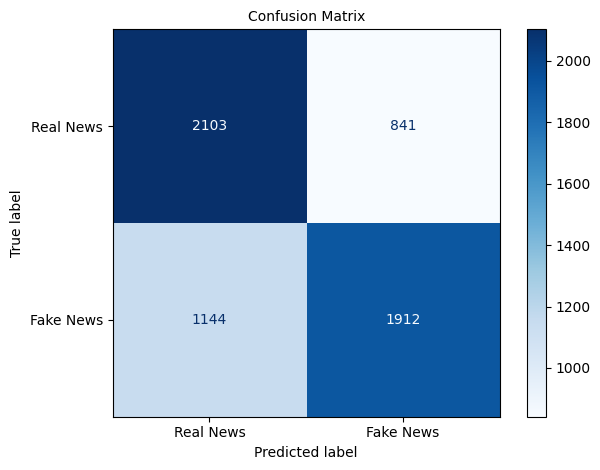

In [8]:
y_pred = model.predict(X_test_emb)
evaluate_model(y_test=y_test, y_pred=y_pred)